# Exploration 4

# 프로젝트 : 작사가 만들기🖋

### 데이터 불러오기

In [1]:
import re    
import glob
import numpy as np         
import tensorflow as tf    
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # 텍스트를 라인 단위로 끊어서 읽어오기
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus)) # 187,088
print("Examples:\n", raw_corpus[:5]) # 데이터 확인

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth']


### 문장 전처리

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고, 양쪽 공백을 지움
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿈
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
    sentence = sentence.strip() # 다시 양쪽 공백을 지움
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start>, 끝에는 <end>를 추가
    return sentence

# 이 문장이 어떻게 필터링되는지 확인
print(preprocess_sentence("This @_is ;;;sample ^-^* :-: _%_%- sentence."))

<start> this is sample sentence . <end>


### preprocess_sentence로 정제한 문장을 모음

In [3]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

### 토큰화

In [4]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만듦
    # 우리는 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꾸기
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게함
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc34dc89ca0>


In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


### data 분리

In [7]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


In [8]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state =15)
enc_val_train, enc_val_val, dec_val_train, dec_val_val = train_test_split(enc_train, dec_train, test_size = 0.125, random_state = 15)
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)
print('Source Val Train: ', enc_val.shape)
print('Target Val Train: ', dec_val.shape)

Source Train:  (124981, 14)
Target Train:  (124981, 14)
Source Val Train:  (31246, 14)
Target Val Train:  (31246, 14)


In [9]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듦
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### 모델 정의 및 학습

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [14]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣기
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 3.56398559e-05, -6.29658098e-05,  1.30242197e-05, ...,
         -1.13284339e-04,  1.46258943e-04, -2.07133009e-04],
        [ 3.89868583e-05, -6.08379603e-04, -1.63663557e-04, ...,
         -2.75334372e-04,  1.23286387e-04, -2.60725152e-04],
        [-5.71938072e-05, -6.77721982e-04, -3.12170829e-04, ...,
         -1.96390552e-04,  6.75366318e-05, -3.67402536e-04],
        ...,
        [ 3.35100660e-04, -5.14908606e-05,  6.25402026e-04, ...,
         -6.10218740e-05,  5.22129063e-04, -3.22918291e-04],
        [ 3.55314201e-04,  1.72376589e-04,  7.34286616e-04, ...,
         -2.48864875e-04,  3.19511688e-04, -2.97958642e-04],
        [ 3.21010011e-04,  3.84188344e-04,  7.98619236e-04, ...,
         -4.21304867e-04,  1.11274043e-04, -2.52041908e-04]],

       [[ 3.56398559e-05, -6.29658098e-05,  1.30242197e-05, ...,
         -1.13284339e-04,  1.46258943e-04, -2.07133009e-04],
        [ 1.44533013e-04, -7.97760949e-05, -2

In [15]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5470560   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8790624   
_________________________________________________________________
dense_1 (Dense)              multiple                  12589049  
Total params: 29,922,489
Trainable params: 29,922,489
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [16]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, validation_data=(enc_val_val, dec_val_val))

Epoch 1/10
489/489 [==============================] - 89s 177ms/step - loss: 3.5168 - val_loss: 3.1285
Epoch 2/10
489/489 [==============================] - 91s 187ms/step - loss: 3.0287 - val_loss: 2.9117
Epoch 3/10
489/489 [==============================] - 94s 192ms/step - loss: 2.8564 - val_loss: 2.7628
Epoch 4/10
489/489 [==============================] - 96s 196ms/step - loss: 2.7281 - val_loss: 2.6390
Epoch 5/10
489/489 [==============================] - 97s 198ms/step - loss: 2.6200 - val_loss: 2.5378
Epoch 6/10
489/489 [==============================] - 97s 198ms/step - loss: 2.5223 - val_loss: 2.4379
Epoch 7/10
489/489 [==============================] - 97s 198ms/step - loss: 2.4317 - val_loss: 2.3511
Epoch 8/10
489/489 [==============================] - 97s 198ms/step - loss: 2.3457 - val_loss: 2.2639
Epoch 9/10
489/489 [==============================] - 97s 198ms/step - loss: 2.2636 - val_loss: 2.1809
Epoch 10/10
489/489 [==============================] - 97s 198ms/step - l

### loss 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

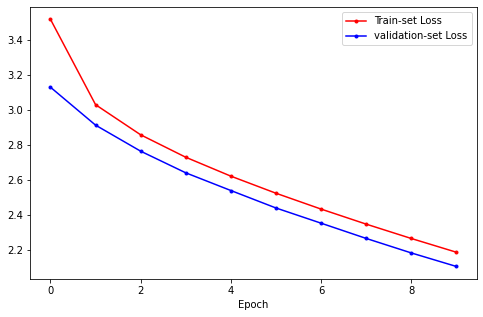

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show

### 문장생성

In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1 입력받은 문장의 텐서를 입력
        predict = model(test_tensor) 
        # 2 예측된 값 중 가장 높은 확률인 word index를 뽑아내기
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 2에서 예측된 word index를 문장 뒤에 붙이기
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마치기
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [20]:
generate_text(model, tokenizer, init_sentence="<start> i", max_len=20)

'<start> i m gonna make you feel like a <unk> <end> '

# 회고
자연어 처리가 굉장히 어렵고 학습이 오래 걸린다는 것을 깨달았다. 나름대로 코드를 짜서 실행해보았지만 결과가 잘 나오지 않아서 많이 좌절했었다.

아마 validation loss를 2.2이하까지 내려야 해서 더욱 힘들지 않았나싶다...

그리고 왜 어려웠는지 생각해보니 정규표현식이 익숙하지 않았었다. 

그래서 이후에 시간을 따로 내서 이번 노드를 토대로 조금 더 이해하는 시간을 가져봐야겠다.

이번에는 조원분들이 매우 열성적으로 도와주셔서 잘 마무리 했던 노드였던것같다.🍀